In [26]:
!pip install torchviz

In [128]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device2 = torch.device('cpu')
print(device)
print(device2)

cuda
cpu


In [129]:
!nvidia-smi

Thu Aug  6 14:54:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    31W / 250W |    895MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [130]:
#データのロード
import tensorflow as tf
#訓練データとそれ以外に分ける
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(60000, 1, 1, 28, 28).astype('float32')
X_test = X_test.reshape(10000, 1, 1, 28, 28).astype('float32')

#標準化
X_train /= 255
X_test /= 255

Y_train = Y_train.astype('long')
Y_test = Y_test.astype('long')
 
#テスト用データと検証用データに分ける
from sklearn.model_selection import train_test_split
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5)

batch_size = 100
print(X_val.shape, Y_val.shape)

(5000, 1, 1, 28, 28) (5000,)


In [138]:
import torch.nn.functional as F
#モデルの構築
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 16, 4, 2, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.dropout1 = nn.Dropout(0.30)
    self.dropout2 = nn.Dropout(0.60)

    self.layer1 = nn.Linear(32*7*7, 128)
    self.layer2 = nn.Linear(128, 10)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = F.max_pool2d(x, (2, 2))
    x = self.dropout1(x)

    x = x.view(-1, 32*7*7)
    x = self.relu(self.layer1(x))
    x = self.dropout2(x)
    x = self.relu(self.layer2(x))
    return x
 
model = CNN()
model = model.to(device)

In [140]:
#誤差関数、学習率、最適化手法の指定
criterion = nn.CrossEntropyLoss()
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [141]:
#訓練、検証
def train(x_train, y_train):
  model.train()
  x_train = torch.from_numpy(x_train).to(device)
  y_train = torch.from_numpy(np.array(y_train)).to(device)
  y_train = (y_train.view(1, ))
  optimizer.zero_grad()
  pred_y = model(x_train)
  loss = criterion(pred_y, y_train)
  loss.backward()
  optimizer.step()
  return loss.item()

def eval(x_val, y_val):
  model.eval()
  x_val = torch.from_numpy(x_val).cuda()
  y_val = torch.from_numpy(np.array(y_val)).cuda()
  pred_y = model(x_val)
  y_val = (y_val.view(1, ))
  loss = criterion(pred_y, y_val)
  pred = pred_y.argmax()
  if pred == y_val:
    acc = 1
  else:
    acc = 0
  return acc

In [142]:
#epoch数の指定
EPOCHS = 200

loss_train_history = []
acc_history = []

for epoch in range(EPOCHS):
  loss_train = 0
  acc = 0

  for i in range(batch_size):
    n = np.random.randint(0, high=len(X_train))
    train_x, train_y = X_train[n], Y_train[n]
    loss_train_i = train(train_x, train_y)
    loss_train += loss_train_i

  for i in range(batch_size):
    n = np.random.randint(0, high=len(X_val))
    val_x, val_y = X_val[n], Y_val[n]
    acc_i = eval(val_x, val_y)
    acc += acc_i
  
  loss_train = loss_train / batch_size
  acc = acc / batch_size

  loss_train_history.append(loss_train)
  acc_history.append(acc)
  print("epoch: ", epoch)
  print("loss_train: ", loss_train)
  print("acc: ", acc)

epoch:  0
loss_train:  2.279551045894623
acc:  0.11
epoch:  1
loss_train:  2.2703560322523115
acc:  0.17
epoch:  2
loss_train:  2.265518225431442
acc:  0.1
epoch:  3
loss_train:  2.244058124385774
acc:  0.13
epoch:  4
loss_train:  2.235410558581352
acc:  0.18
epoch:  5
loss_train:  2.1204454689472914
acc:  0.14
epoch:  6
loss_train:  2.1260452610906215
acc:  0.17
epoch:  7
loss_train:  1.9718582347796474
acc:  0.24
epoch:  8
loss_train:  2.000078048300347
acc:  0.22
epoch:  9
loss_train:  1.890815596176335
acc:  0.19
epoch:  10
loss_train:  1.8581964313154093
acc:  0.27
epoch:  11
loss_train:  1.859622343988076
acc:  0.27
epoch:  12
loss_train:  1.9741784056959977
acc:  0.23
epoch:  13
loss_train:  2.0196416407427025
acc:  0.24
epoch:  14
loss_train:  1.8629039542190093
acc:  0.24
epoch:  15
loss_train:  1.8342054893082196
acc:  0.23
epoch:  16
loss_train:  1.8298772678768729
acc:  0.26
epoch:  17
loss_train:  1.874660847280237
acc:  0.28
epoch:  18
loss_train:  1.9151515758842652
acc:

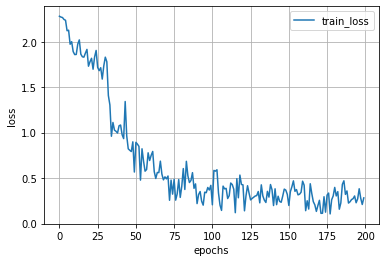

In [143]:
import matplotlib.pyplot as plt

#lossの推移
plt.plot(loss_train_history, marker=' ', label='train_loss')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

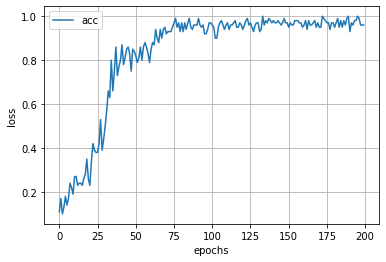

In [144]:
#正解率の推移
plt.plot(acc_history, marker=' ', label='acc')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

t:True<br>
f:False<br>
p:Positive<br>
n:Negative

In [155]:
#それぞれの選択肢についてtp,fp,tn,fnを計測
def tp_fp_tn_fn(n):
  tp = 0
  fp = 0
  tn = 0
  fn = 0
  for i in range(len(X_test)):
    model.eval()
    x_test = torch.from_numpy(X_test[i]).cuda()
    y_test = torch.from_numpy(np.array(Y_test[i])).cuda()
    pred_y = model(x_test)
    y_test = (y_test.view(1, ))
    loss = criterion(pred_y, y_test)
    pred = pred_y.argmax()
    if pred == n:
      if pred == y_test:
        tp += 1
      else:
        fp += 1
    else:
      if pred == y_test:
        tn += 1
      else:
        fn += 1
  
  return tp, fp, tn, fn

In [158]:
#tp, fp, tn, fnからそれぞれを求める
def pRECISION(tp, fp, tn, fn):
  return tp / (tp + fp)

def rECALL(tp, fp, tn, fn):
  return tp / (tp + fn)

def f_SCORE(recall, precision):
  return 2*recall*precision/(recall + precision)

In [166]:
for i in range(10):
  tp, fp, tn, fn = tp_fp_tn_fn(i)
  print("label: ",i)
  print("tp:",tp, "fp:",fp,"tn:", tn,"fn:", fn)
  precision = pRECISION(tp, fp, tn, fn)
  print("precision: ",precision)
  recall = rECALL(tp, fp, tn, fn)
  print("recall: ",recall)
  f_score = f_SCORE(recall, precision)
  print("f_score: ",f_score)
  print("~~~~~~~~~~~~~~~")

label:  0
tp: 487 fp: 20 tn: 4379 fn: 114
precision:  0.960552268244576
recall:  0.8103161397670549
f_score:  0.8790613718411552
~~~~~~~~~~~~~~~
label:  1
tp: 572 fp: 8 tn: 4294 fn: 126
precision:  0.9862068965517241
recall:  0.8194842406876791
f_score:  0.895148669796557
~~~~~~~~~~~~~~~
label:  2
tp: 538 fp: 23 tn: 4328 fn: 111
precision:  0.9590017825311943
recall:  0.8289676425269645
f_score:  0.8892561983471073
~~~~~~~~~~~~~~~
label:  3
tp: 485 fp: 5 tn: 4381 fn: 129
precision:  0.9897959183673469
recall:  0.7899022801302932
f_score:  0.8786231884057971
~~~~~~~~~~~~~~~
label:  4
tp: 450 fp: 19 tn: 4416 fn: 115
precision:  0.9594882729211087
recall:  0.7964601769911505
f_score:  0.8704061895551258
~~~~~~~~~~~~~~~
label:  5
tp: 454 fp: 21 tn: 4412 fn: 113
precision:  0.9557894736842105
recall:  0.800705467372134
f_score:  0.871401151631478
~~~~~~~~~~~~~~~
label:  6
tp: 456 fp: 5 tn: 4410 fn: 129
precision:  0.9891540130151844
recall:  0.7794871794871795
f_score:  0.8718929254302102
~